# Add USGS stations in the station location file

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
fn = Path("../../data/gunnison_reservoirs/gunnison_reservoirs_locations_fdrcorrected.csv")
rat_stations = pd.read_csv(fn)
rat_stations.head()

,run,name,lon,lat
0,1,Taylor Park,-106.604289,38.820602
1,1,Blue Mesa,-107.333611,38.453670
2,1,Morrow Point,-107.487750,38.410742
3,1,Silver Jack,-107.540387,38.230238


In [5]:
# read in USGS gage locations
usgs_fn = Path("../../data/usgs_gage_locations/usgs_gages.csv")
usgs_stations = pd.read_csv(usgs_fn)
usgs_stations.head()

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,9107000,"TAYLOR RIVER AT TAYLOR PARK, CO.",ST,38.860271,-106.566697,S,NAD83,9340.00,10.0,NGVD29,14020001,POINT (-106.5666966 38.86027127)
1,USGS,9107500,"TEXAS CREEK AT TAYLOR PARK, CO",ST,38.846944,-106.554639,5,NAD83,9380.00,10.0,NGVD29,14020001,POINT (-106.5546389 38.84694444)
2,USGS,9108250,"WILLOW CREEK ABOVE TAYLOR PARK RESERVOIR, CO.",ST,38.817936,-106.560750,F,NAD83,9368.00,1.6,NAVD88,14020001,POINT (-106.56075 38.8179361)
3,USGS,9109000,"TAYLOR RIVER BELOW TAYLOR PARK RESERVOIR, CO.",ST,38.818327,-106.609198,F,NAD83,9169.67,15.0,NGVD29,14020001,POINT (-106.6091977 38.8183269)
4,USGS,9110000,"TAYLOR RIVER AT ALMONT, CO.",ST,38.664437,-106.845317,F,NAD83,8010.76,15.0,NGVD29,14020001,POINT (-106.8453172 38.66443715)


In [12]:
# since the name cannot be very long, we'll have to generate unique names for the stations
usgs_stations['rat_name'] = '-'
for i, row in usgs_stations.iterrows():
    name = row['station_nm'][:3]
    count = sum([name in rat_name for rat_name in usgs_stations['rat_name']])
    rat_name = f"{name}{count:02}"
    usgs_stations.loc[i, 'rat_name'] = rat_name
usgs_stations['rat_name']

0     TAY00
1     TEX00
2     WIL00
3     TAY01
4     TAY02
5     ELK00
6     COA00
7     EAS00
8     EAS01
9     OHI00
10    OHI01
11    GUN00
12    GUN01
13    TOM00
14    COC00
15    TOM01
16    LAK00
17    HEN00
18    LAK01
19    CIM00
20    CIM01
21    GUN02
22    NOR00
23    OLD00
24    GUN03
25    SLA00
Name: rat_name, dtype: object

In [17]:
# dataframe to append to rat_stations
usgs_stns_ratfmt = usgs_stations[['rat_name', 'dec_lat_va', 'dec_long_va']].rename({
    'rat_name': 'name',
    'dec_lat_va': 'lat',
    'dec_long_va': 'lon',
}, axis=1)
usgs_stns_ratfmt['run'] = 1

In [19]:
merged_rat_stations = pd.concat([rat_stations, usgs_stns_ratfmt])
merged_rat_stations['name'] = merged_rat_stations['name'].str.replace(' ', '_')
merged_rat_stations

,run,name,lon,lat
0,1,Taylor_Park,-106.604289,38.820602
1,1,Blue_Mesa,-107.333611,38.453670
2,1,Morrow_Point,-107.487750,38.410742
3,1,Silver_Jack,-107.540387,38.230238
0,1,TAY00,-106.566697,38.860271
1,1,TEX00,-106.554639,38.846944
2,1,WIL00,-106.560750,38.817936
3,1,TAY01,-106.609198,38.818327
4,1,TAY02,-106.845317,38.664437
5,1,ELK00,-107.059772,38.856650


In [22]:
dst_fn = fn.with_name('gunnison_reservoirs_fdr_corrected_usgs_gages.csv')
print(dst_fn)
merged_rat_stations.to_csv(dst_fn, index=False)

../../data/gunnison_reservoirs/gunnison_reservoirs_fdr_corrected_usgs_gages.csv


Update the rat_config

In [32]:
from ruamel_yaml import YAML

yaml = YAML()

config_fn = Path("../../params/rat_config.yaml")

config = yaml.load(config_fn.open('r'))
?config

Type:            CommentedMap
String form:     ordereddict([('GLOBAL', ordereddict([('steps', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),  <...> ordereddict([('secrets', '/houston2/pritam/2023_01_24-river-regulation/secrets/secrets.ini')]))])
Length:          11
File:            /houston2/pritam/2023_01_24-river-regulation/.env/lib/python3.9/site-packages/ruamel_yaml/comments.py
Docstring:       <no docstring>
Class docstring: Dictionary that remembers insertion order

In [33]:
config['ROUTING']['station_latlon_path'] = str(dst_fn.resolve())

In [34]:
yaml.dump(config, config_fn)

# Run RAT and open results

In [66]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

<GeoAxesSubplot:>

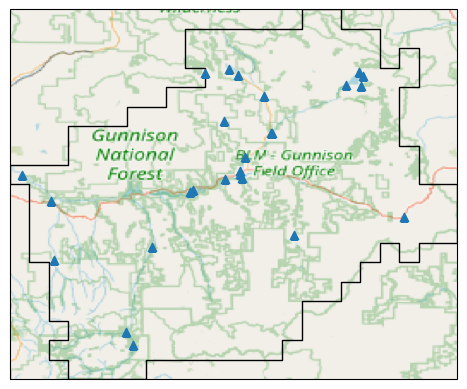

In [86]:
stations_fn = Path("../../data/usgs_gage_locations/usgs_gages.csv")
stations = pd.read_csv(stations_fn, dtype={'site_no': str})
stations['geometry'] = gpd.GeoSeries.from_wkt(stations['geometry'])
stations = gpd.GeoDataFrame(stations)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings('ignore')

fn = Path('../../data/basin_shapefile/gunnison_boundary/gunnison_boundary.shp')

def plot_map(fn, plot_stations=True, plot_boundary=True):
    gunnison_boundary = gpd.read_file(fn)
    gunnison_boundary.bounds.values[0]

    f, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

    extent = gunnison_boundary.bounds[['minx', 'maxx', 'miny', 'maxy']].values[0]
    request = cimgt.OSM()
    ax.set_extent(extent)
    ax.add_image(request, 8)
    if plot_boundary:
        gunnison_boundary.plot(ax=ax, fc='none')
    if plot_stations:
        stations.plot(ax=ax, marker='^')

    return f, ax

f, ax = plot_map(fn)

ax

In [78]:
from rat.utils.utils import clip_ts

<GeoAxesSubplot:>

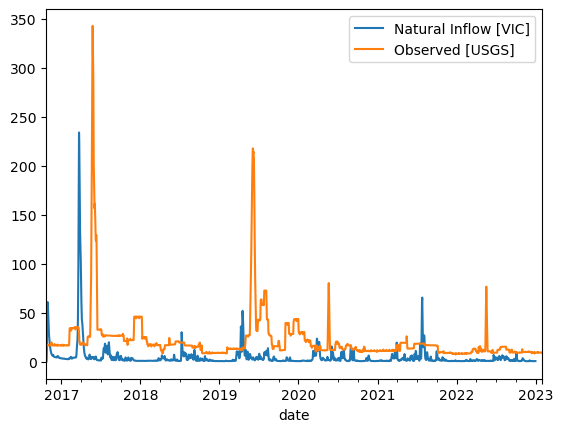

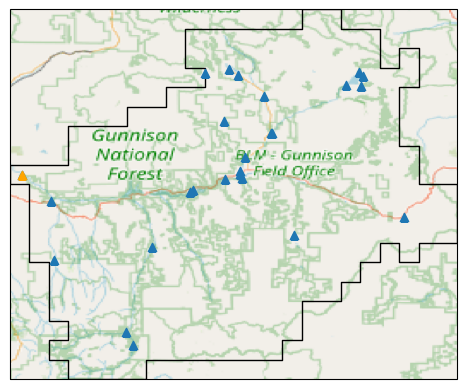

In [128]:
station = stations.iloc[21, :]

rat_inflow_fn = Path(f'../../data/colorado/basins/gunnison/ro/rout_inflow/{station["station_nm"][:3]}00.csv')
rat_inflow = pd.read_csv(rat_inflow_fn, parse_dates=['date']).set_index('date')

f, ax = plt.subplots()
rat_inflow['streamflow'].plot(ax=ax, label='Natural Inflow [VIC]')

obs_inflow_fn = Path(f'../../data/usgs_insitu/{station["site_no"]}.csv')
obs_inflow = pd.read_csv(obs_inflow_fn, parse_dates=['datetime']).rename({'00060_Mean': 'streamflow', 'datetime': 'date'}, axis=1).set_index('date')

obs_inflow['streamflow'][obs_inflow['streamflow'] < 0] = np.nan
obs_inflow['streamflow'] = obs_inflow['streamflow'] * 0.0283168
obs_inflow, rat_inflow = clip_ts(obs_inflow.tz_localize(None), rat_inflow)
obs_inflow['streamflow'].plot(ax=ax, label='Observed [USGS]')

ax.legend()

# plot map
mf, ma = plot_map(fn)
# station.plot(ax=ma)
ma.scatter([station['geometry'].x], [station['geometry'].y], marker='^', color='orange')
ma